In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (9.0, 7.0)
pylab.rcParams['font.size'] = 16
from pandas import *

def removeBurnin(df, frac=0.1):
    n = shape(df)[0]
    return df.tail(int(n*(1.0-frac)))


from scipy.stats import expon
def sampleCFHeights(ntaxa, nsamples):
    heights = zeros(nsamples)
    for i in range(nsamples):
        for k in range(2,ntaxa+1):
            rate = 0.5*k*(k-1)
            heights[i] += expon.rvs(scale=1.0/rate)
    return heights

# Functions for producing validation plots
def drawComparisonPlot(df, dfs, statistic, titleStr=None, bins=100):
    #xmin=min(dfs[statistic].quantile(0.01), df[statistic].quantile(0.01))
    xmin=0
    xmax=max(dfs[statistic].quantile(0.99), df[statistic].quantile(0.99))
    dfs[statistic].hist(normed=True, alpha=0.5, label="Simulated", range=(xmin, xmax), bins=bins)
    df[statistic].hist(normed=True, alpha=0.5, label="MCMC", range=(xmin, xmax), bins=bins)
    if titleStr==None:
        titleStr = statistic
    xlabel(titleStr)
    ylabel('Density')
    title(titleStr)
    legend()

def drawAllComparisonPlots(df, dfs, alignIDs=['locus']):
    drawComparisonPlot(df,dfs,'acg.CFheight', 'Clonal frame height')
    show()
    drawComparisonPlot(df,dfs,'acg.nConv', 'Conversion count')
    show()
    for alignID in alignIDs:
        drawComparisonPlot(df, dfs, 'acg.' + alignID + '.meanTractLength', 'Tract length ({})'.format(alignID))
        show()
        drawComparisonPlot(df, dfs, 'acg.' + alignID + '.meanRegionLength', 'Region length')
        show()
    drawComparisonPlot(df, dfs, 'acg.meanDepartureHeight', 'Conversion edge departure heights')
    show()
    drawComparisonPlot(df, dfs, 'acg.meanEdgeLength', 'Conversion edge lengths')

Populating the interactive namespace from numpy and matplotlib


BACTER Validation
=================

Theory
------

We define a restricted ACG $A=(C,M,R)$ where $C$ is a phylogenetic tree representing the _clonal frame_, $M$ is a map identifying the number and locations of regions on the sequence alignment $S$ affected by the conversion events, and $R$ is a set of recombinant edges which depart from and attach to points on the clonal frame.

The parameters of the model are the conversion rate  $\rho$ (per unit time, per site), the expected tract length  $\delta$ and the population size parameter $\theta$.

Our MCMC algorithm seeks to sample from the joint posterior density
\begin{equation}
P(A,\theta,\rho,\delta|S) \propto P(S|A)P(A|\theta,\rho,\delta)P(\theta,\rho,\delta)
\end{equation}

To test our sampler implementation, however, we sample instead from
\begin{equation}
P(A|\theta,\rho,\delta) = P(R|M,C,\theta)P(M|C,\rho,\delta)P(C|\rho,\delta)
\end{equation}

The clonal frame height distribution should simply be its distribution under the coalescent with a constant population size of 1. That is

\begin{equation}
    P(t_{CF})=e^{-t_{CF}}
\end{equation}

Add/remove operator
-------------------

### Full two-taxon comparison

I've simulated $10^5$ two-taxon ACGs with $\rho=5\times10^{-3}$ and $\delta=50$ under the model.  I've also used the add/remove operator in conjunction with the ACG scaling operator to produce a chain of ARGs of length $10^8$ with the same parameters. The first 10% of the MCMC chain is discarded to ensure we are past burn-in.

In [2]:
dfs = read_table('ACGsimulations/simulateACGs2taxon.stats')
df = removeBurnin(read_table('addRemoveTests/addRemoveTest2taxon.stats'))

The clonal frame height distribution should simply be its distribution under the coalescent with a constant population size of 1. That is

\begin{equation}
    P(t_{CF})=e^{-t_{CF}}
\end{equation}

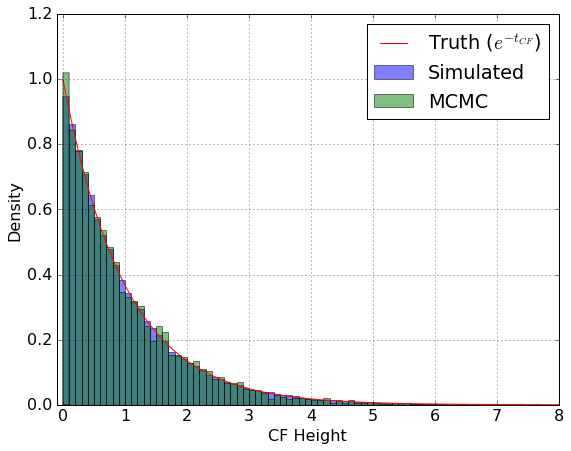

In [3]:
bins=arange(0,10,0.1)
dfs['acg.CFheight'].hist(bins=bins,normed=True, alpha=0.5, label="Simulated")
df['acg.CFheight'].hist(bins=bins, normed=True, alpha=0.5, label="MCMC")
plot(bins, exp(-bins), label=r"Truth ($e^{-t_{CF}}$)")
xlim((-.1,8))
xlabel('CF Height')
ylabel('Density')
legend()

The distribution of conversion counts is shown below.  Note that the distribution here is similar to the CF height distribution, as the number of conversions is drawn from a Poisson distribution with mean $2\rho t_{CF}$.

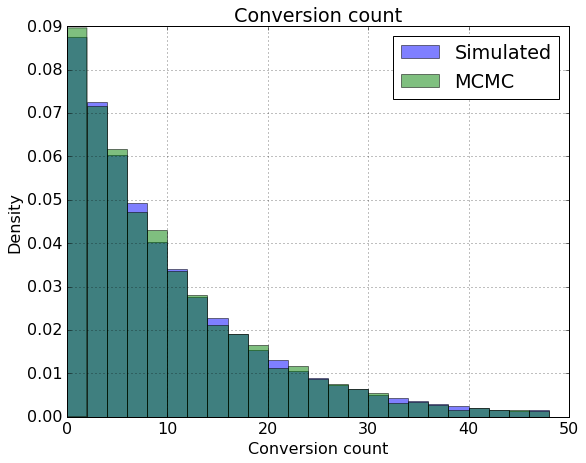

In [4]:
drawComparisonPlot(df,dfs,'acg.nConv', 'Conversion count', bins=24)

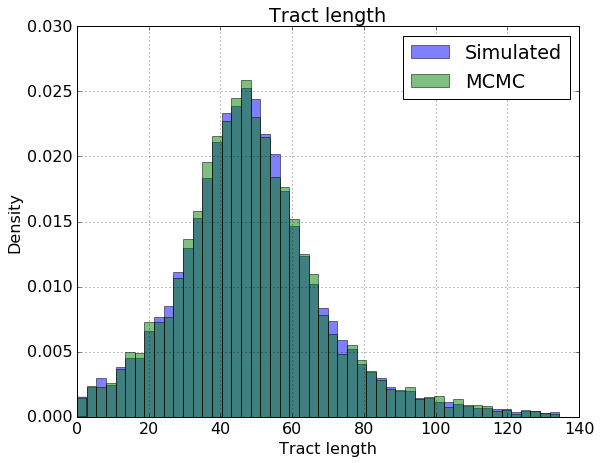

In [5]:
drawComparisonPlot(df, dfs, 'acg.locus.meanTractLength', 'Tract length', bins=50)

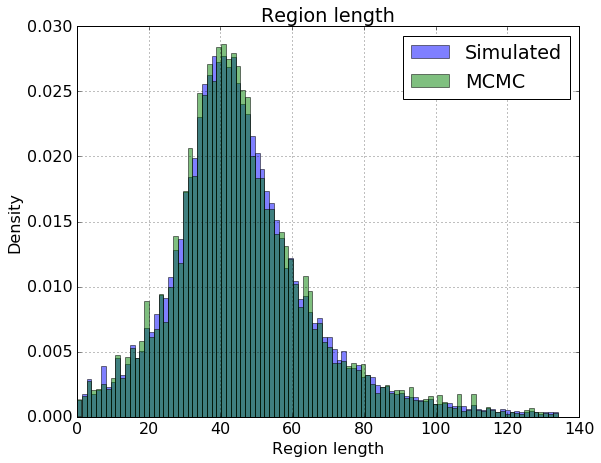

In [6]:
drawComparisonPlot(df, dfs, 'acg.locus.meanRegionLength', 'Region length', bins=100)

The distributions of mean edge length and departure height also differ, although I don't have analytical expressions for the truth there.

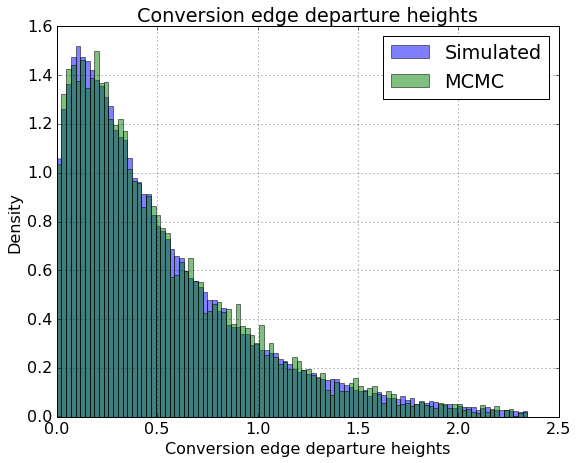

In [7]:
drawComparisonPlot(df, dfs, 'acg.meanDepartureHeight', 'Conversion edge departure heights')

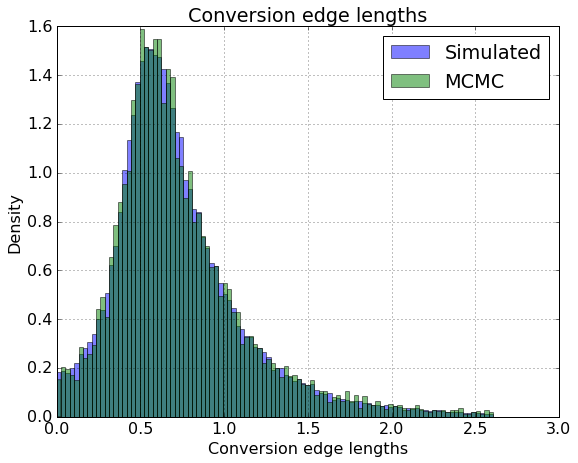

In [8]:
drawComparisonPlot(df, dfs, 'acg.meanEdgeLength', 'Conversion edge lengths')

### 5 taxon comparison

The space of 5 taxon ARGs is a lot more complicated.  We need to invoke the full suite of tree operators to walk the space of possible clonal frames.  Thankfully, we can reuse the standard BEAST operators here by wrapping them in code that ensures they do not propose CFs inconsistent with any existing recombinant edges.

In [2]:
dfs = read_table('ACGsimulations/simulateACGs5taxon.stats')
df = removeBurnin(read_table('addRemoveTests/addRemoveTest5taxon.stats'))

The clonal frame height distributions obtained from the MCMC and an ensemble of ARGs simulated under the same model are shown below.

The clonal frame height distribution is ridiculously easy to sample.  It is less easy to sample in the ARG simulator because there we care about the generated CF topology.  Thus, we also compare both simulated and MCMC results with the a distribution of heights sampled directly from the appropriate hypoexponential distribution.

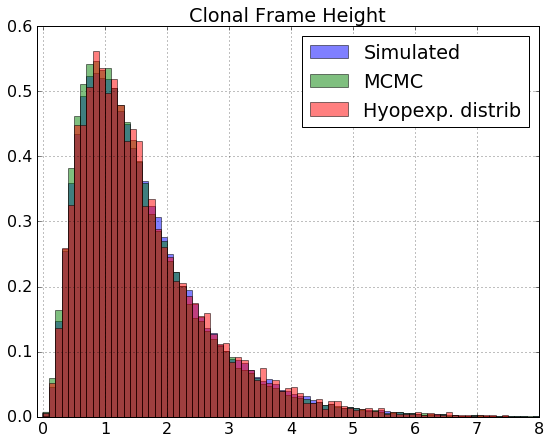

In [3]:
bins=arange(0,10,0.1)
dfs['acg.CFheight'].hist(bins=bins,normed=True,
                         alpha=0.5, label="Simulated")
df['acg.CFheight'].hist(bins=bins, normed=True,
                        alpha=0.5, label="MCMC")
DataFrame(sampleCFHeights(5, 10000))[0].hist(bins=bins,
                                             normed=True,
                                             alpha=0.5,
                                             label="Hyopexp. distrib")
xlim((-.1,8))
title('Clonal Frame Height')
legend()

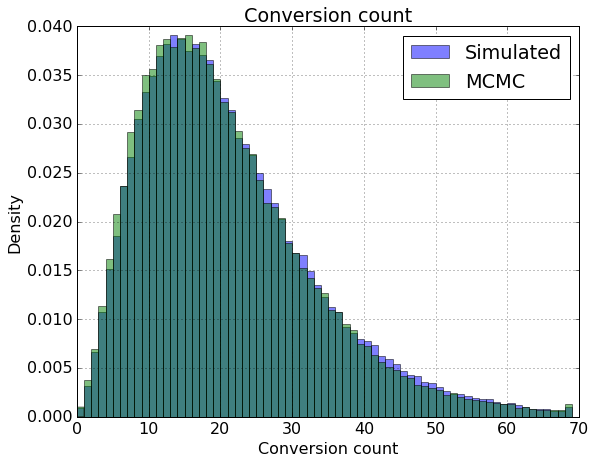

In [47]:
drawComparisonPlot(df,dfs,'acg.nConv', 'Conversion count', bins=arange(70))

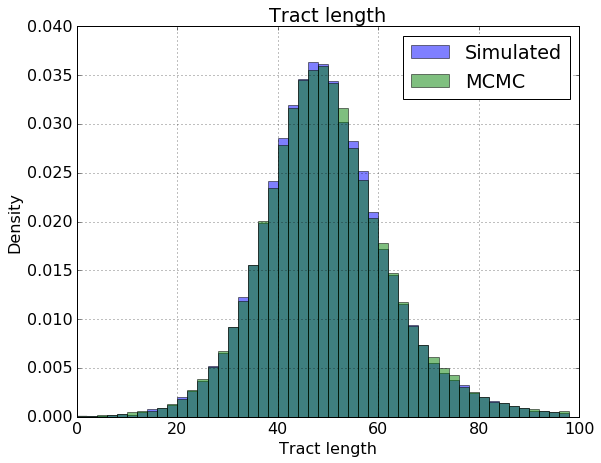

In [48]:
drawComparisonPlot(df, dfs, 'acg.locus.meanTractLength', 'Tract length', bins=arange(0,100,2))

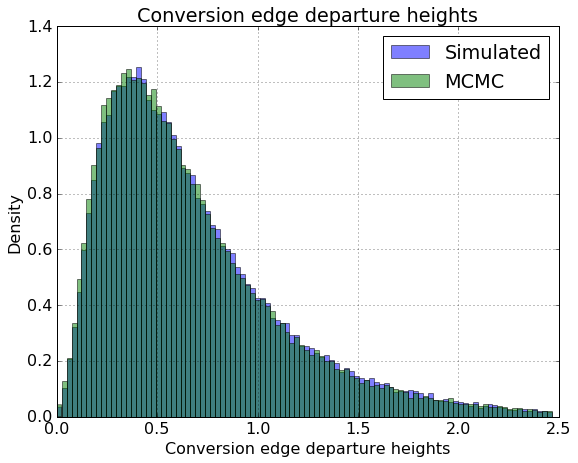

In [49]:
drawComparisonPlot(df, dfs, 'acg.meanDepartureHeight', 'Conversion edge departure heights')

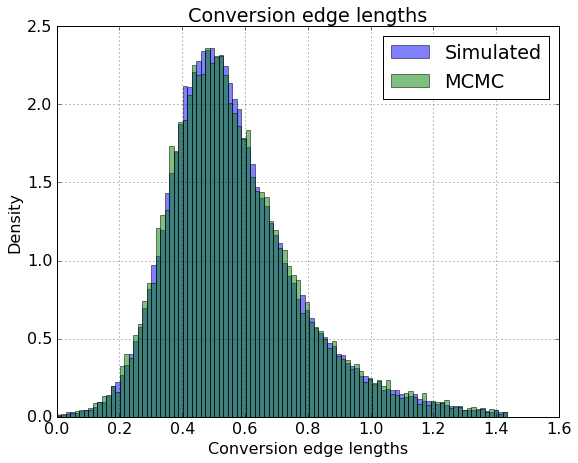

In [33]:
drawComparisonPlot(df, dfs, 'acg.meanEdgeLength', 'Conversion edge lengths')

### Dynamic population sizes

Here the population parameter $\theta$ is replaced by a time-dependent function $\theta(t)=\theta_0e^{-\lambda t}$ where $t$ increases into the past, $\theta_0=10$ and $\lambda=0.1$.

In [25]:
dfs = read_table('ACGsimulations/simulateACGs5taxonDynamicPopSize.stats')
df = read_table('addRemoveTests/addRemoveDynamicPopSize5taxon.stats')

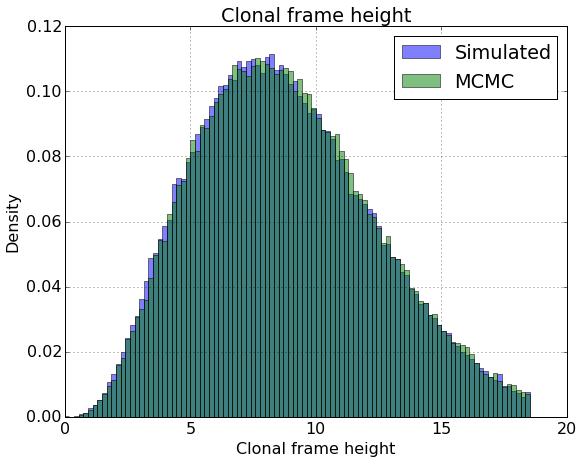

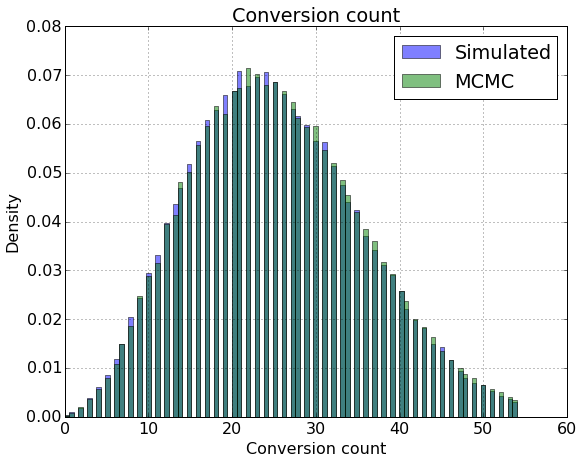

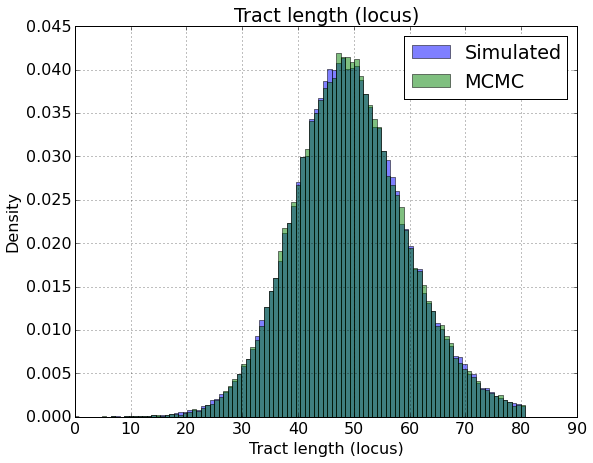

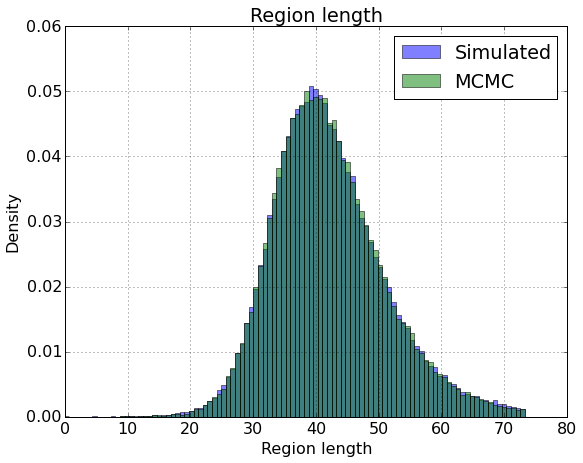

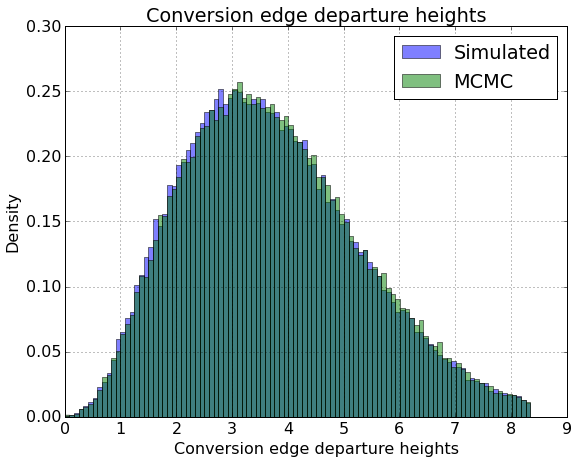

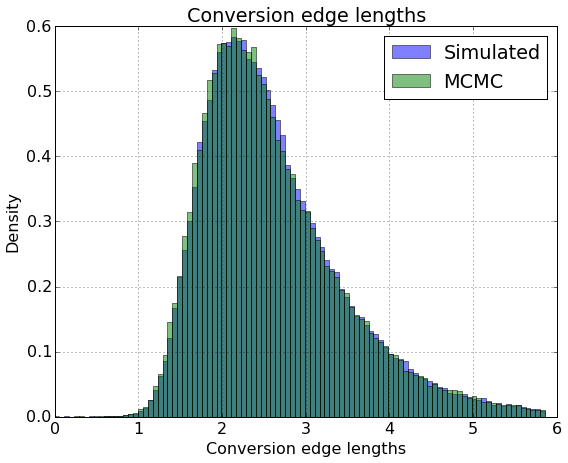

In [28]:
drawAllComparisonPlots(df, dfs)

Add/remove redundant conversion operator
----------------------------------------

In [30]:
dfs = read_table('ACGsimulations/simulateACGs5taxon.stats')
df = read_table('addRemoveTests/addRemoveRedundantTest5taxon.stats')

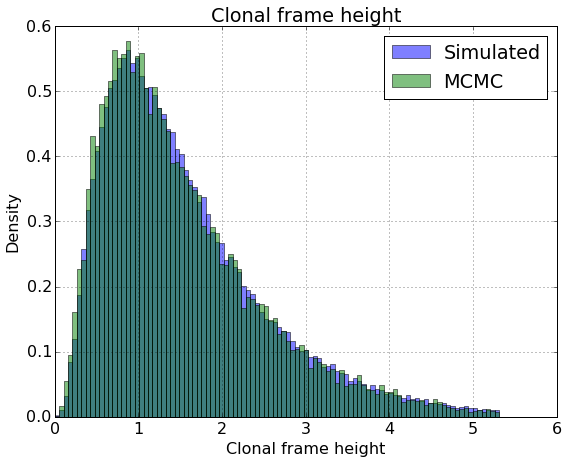

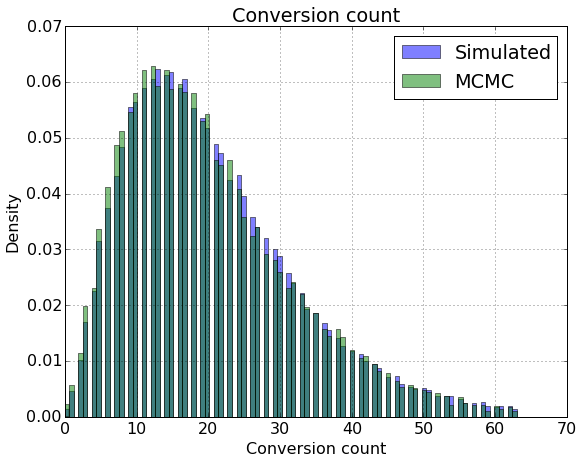

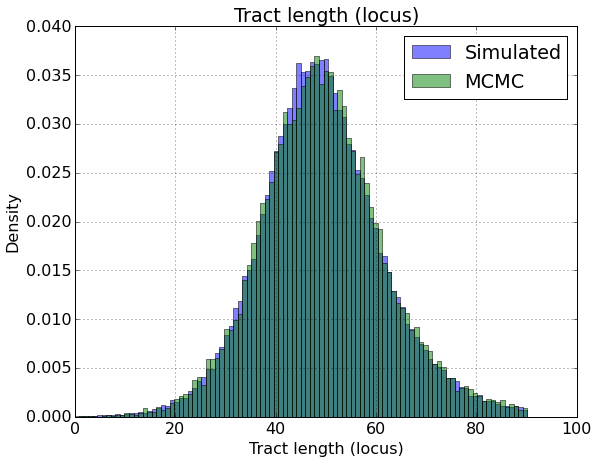

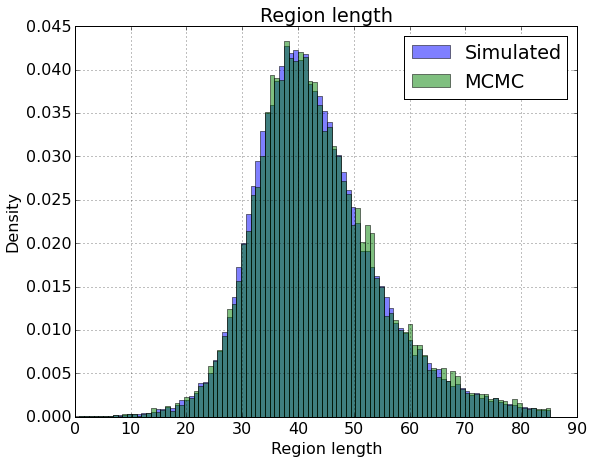

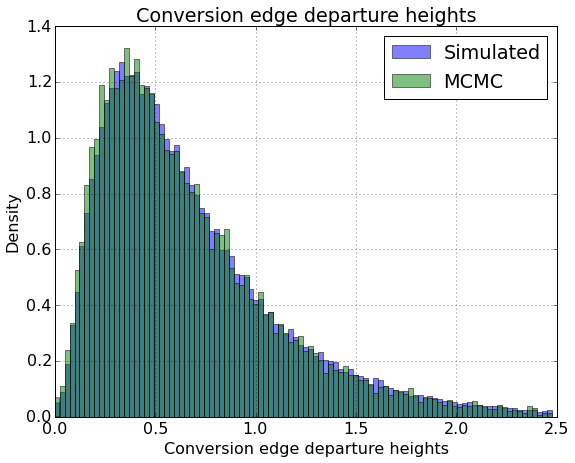

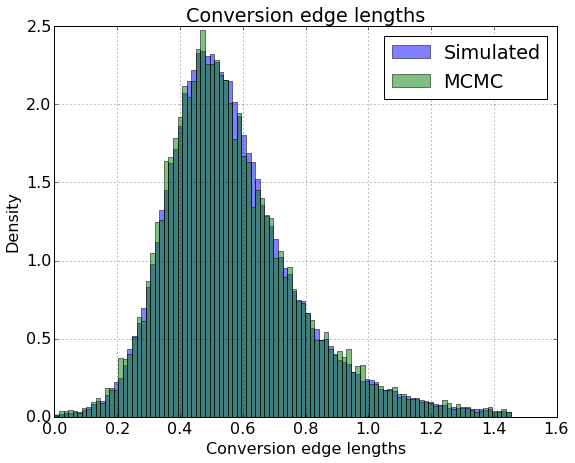

In [31]:
drawAllComparisonPlots(df, dfs)

Region shift operators
----------------------

These operators just shift the position of converted regions along the alignment.  They do not affect the ordering of these regions.  There are currently two such operators, the region boundary shift operator (ConvertedRegionBoundaryShift) which only shifts a single boundary of a chosen region, and the region shift operator (ConvertedRegionShift) which shifts the whole region but leaves the size of the region unchanged.

As these operators cannot form an ergodic chain in isolation, they are tested here in concert with the recombination add/remove operator.  They also simultaneously test the region swap operator (ConvertedRegionSwap) as this operator is simple enough (famous last words) not to need its own test.

### Boundary shift operator

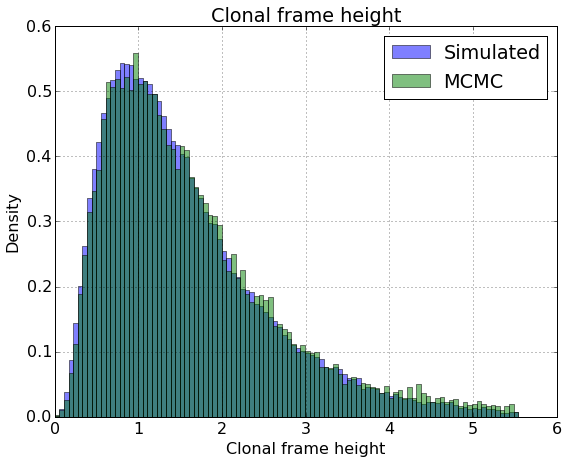

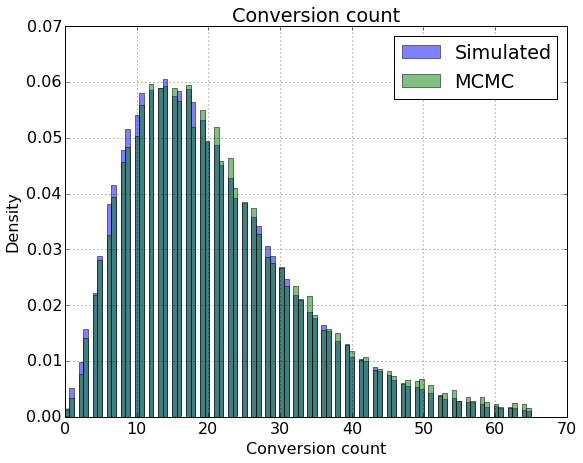

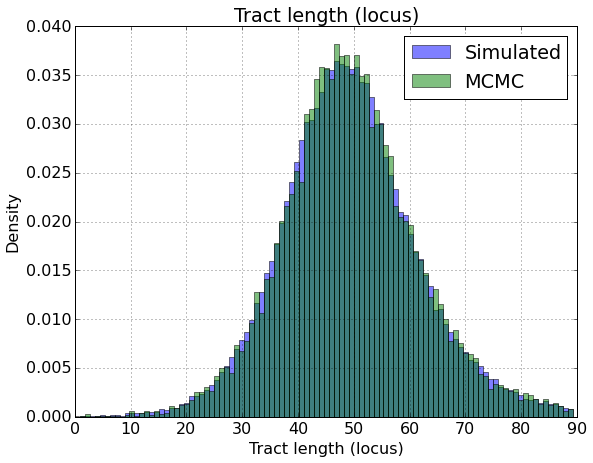

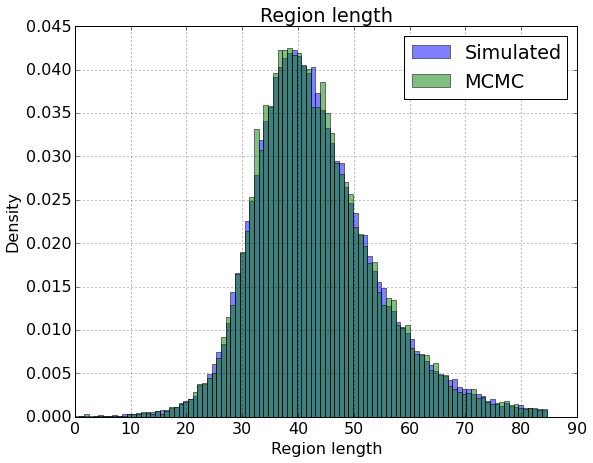

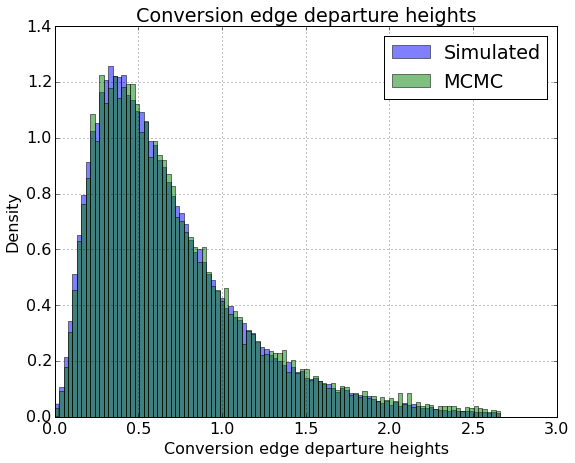

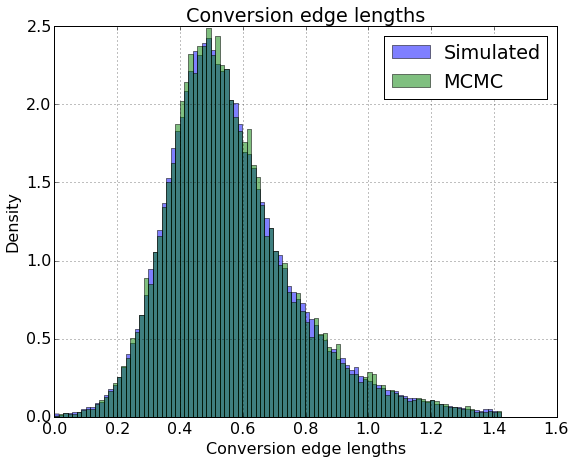

In [87]:
dfs = read_table('ACGsimulations/simulateACGs5taxon.stats')
df = removeBurnin(read_table('regionShiftTests/boundaryShiftTest5taxon.stats'))
drawAllComparisonPlots(df, dfs)

### Region shift operator

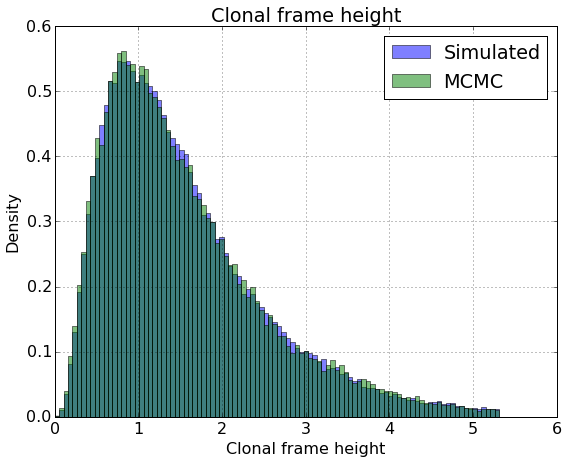

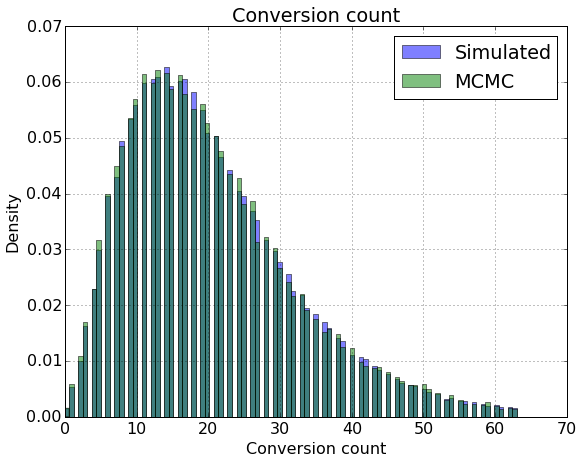

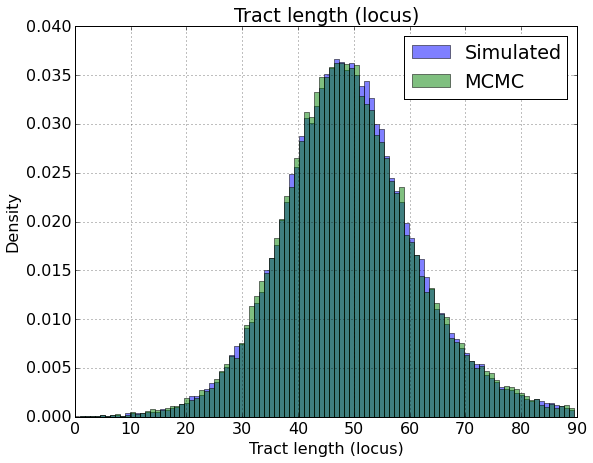

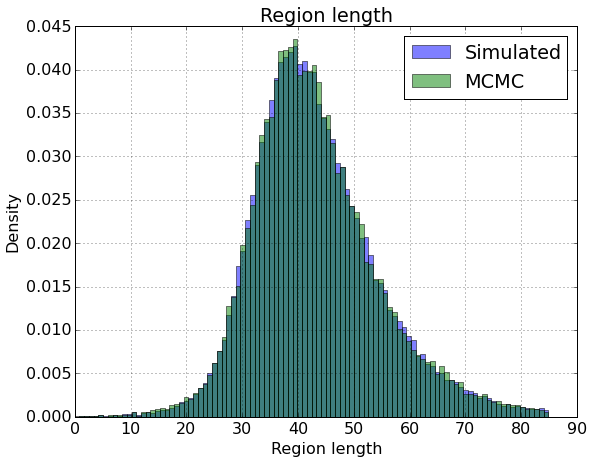

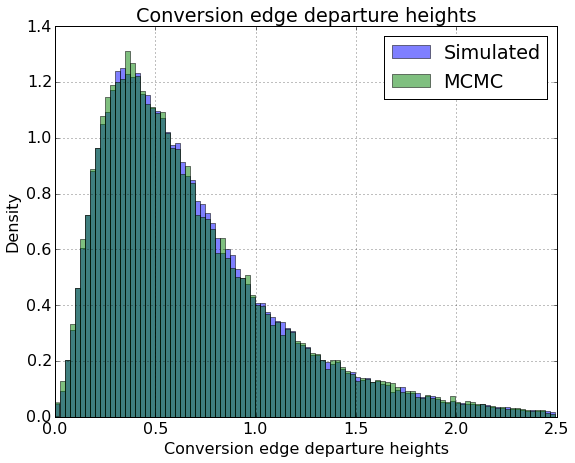

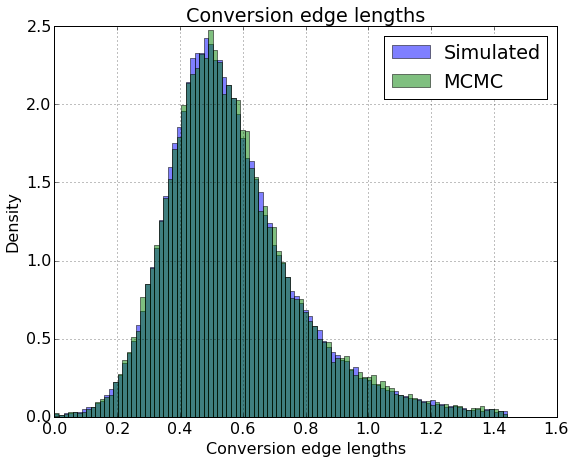

In [88]:
dfs = read_table('ACGsimulations/simulateACGs5taxon.stats')
df = removeBurnin(read_table('regionShiftTests/regionShiftTest5taxon.stats'))
drawAllComparisonPlots(df, dfs)

## Merge/split operator

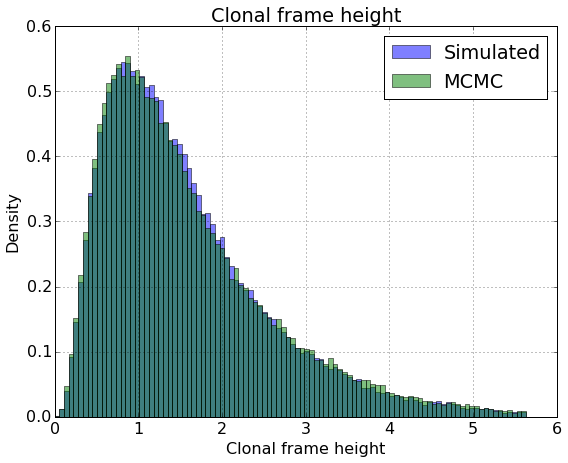

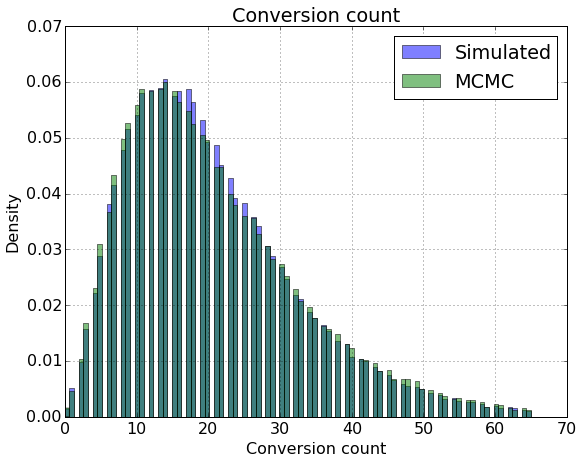

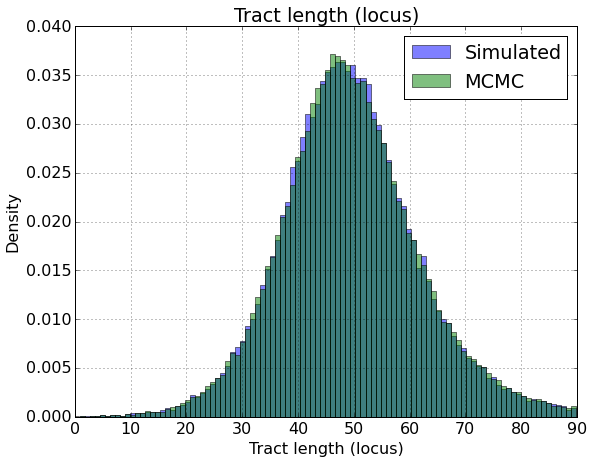

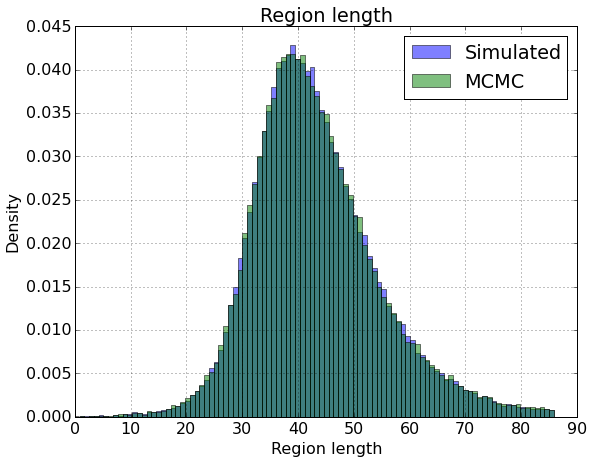

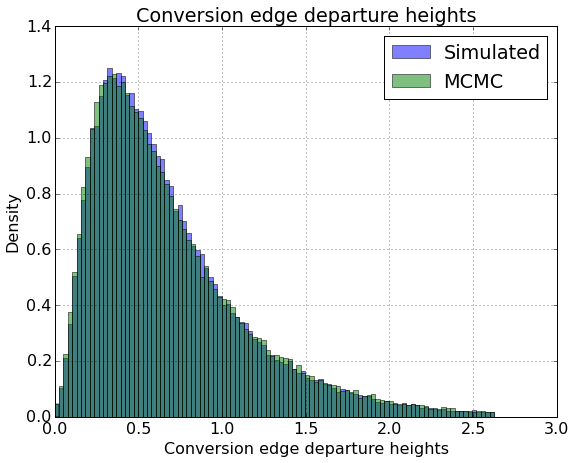

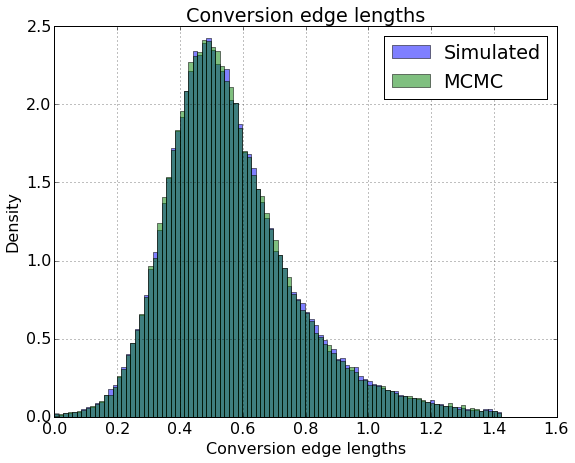

In [86]:
dfs = read_table('ACGsimulations/simulateACGs5taxon.stats')
df = removeBurnin(read_table('mergeSplitTests/mergeSplitTest5taxon.stats'))
drawAllComparisonPlots(df, dfs)

## Detour add/remove operator

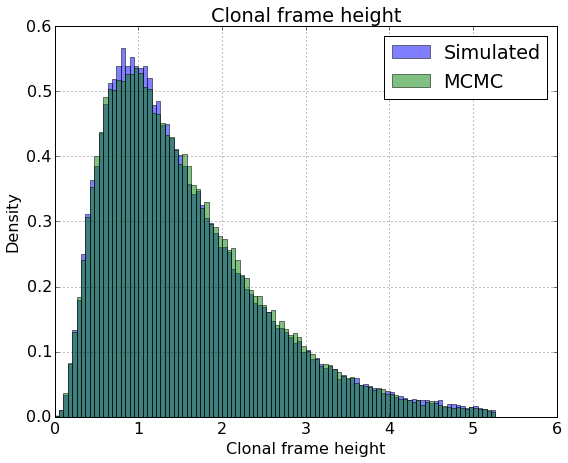

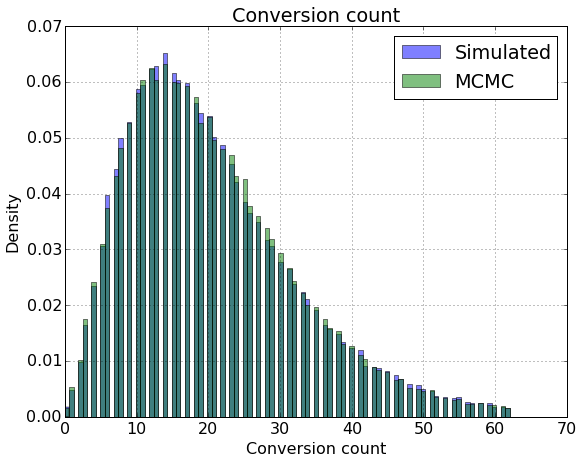

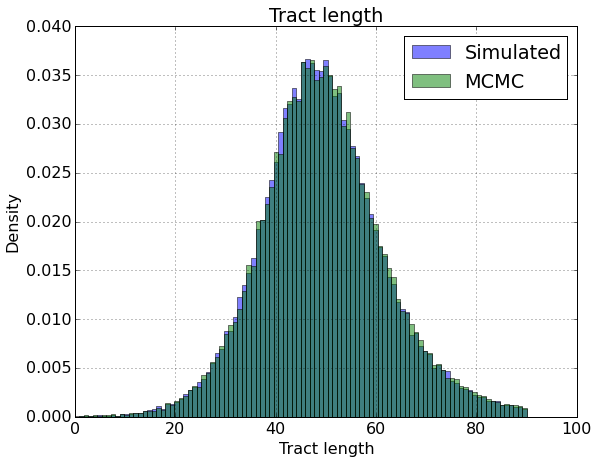

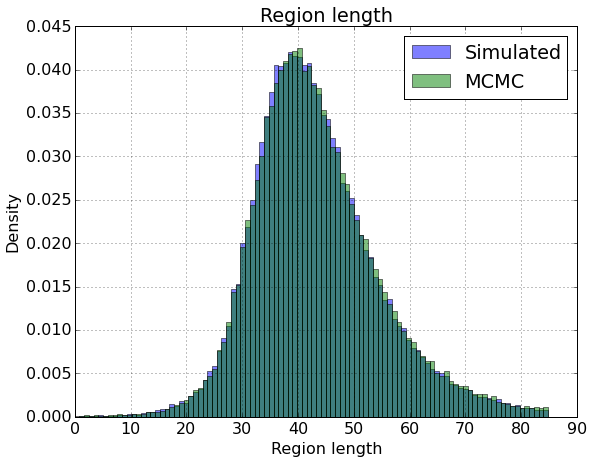

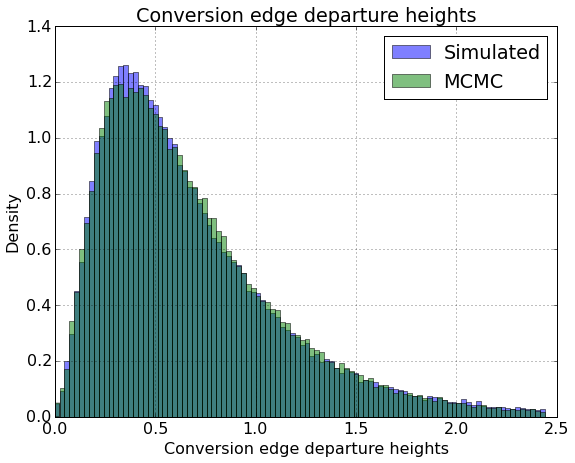

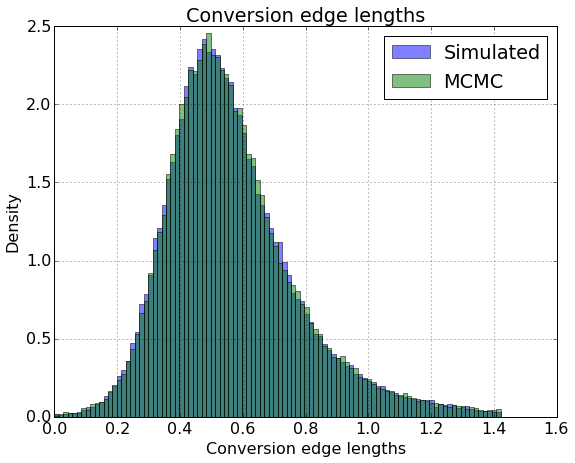

In [66]:
dfs = read_table('ACGsimulations/simulateACGs5taxon.stats')
df = removeBurnin(read_table('addRemoveDetourTests/addRemoveDetourTest5taxon.stats
drawAllComparisonPlots(df, dfs)

## CF Uniform operator

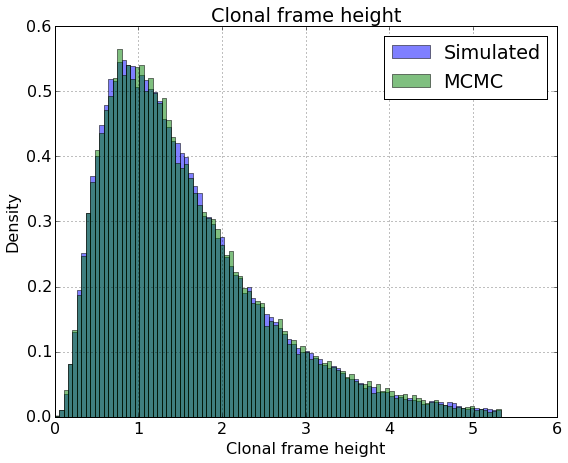

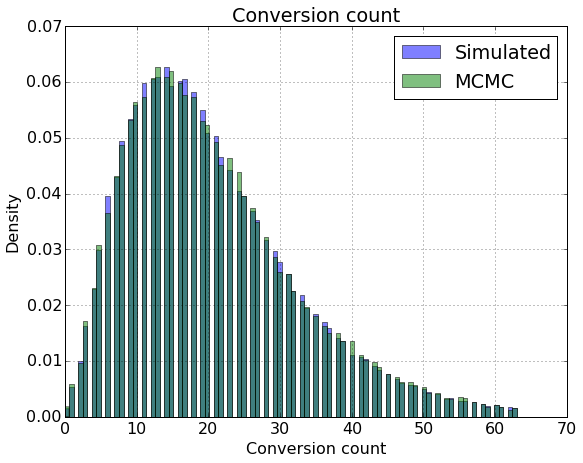

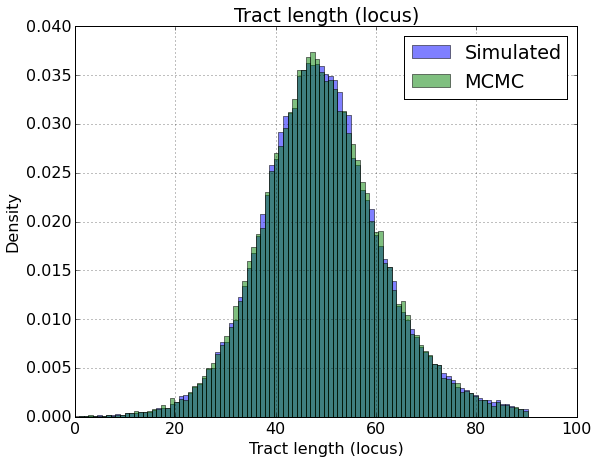

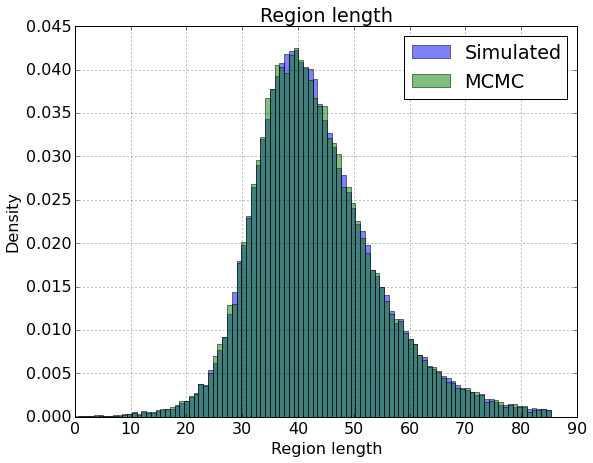

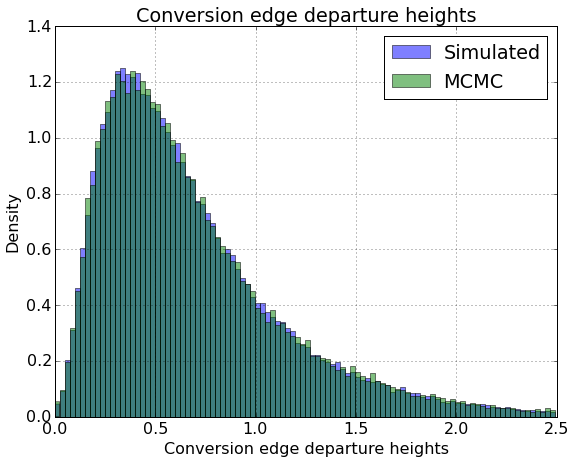

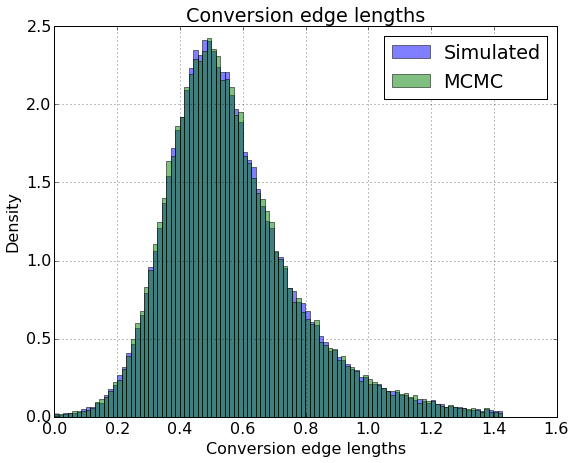

In [41]:
dfs = read_table('ACGsimulations/simulateACGs5taxon.stats')
df = removeBurnin(read_table('CFOperatorTests/CFUniformTest5taxon.stats'))
drawAllComparisonPlots(df, dfs)

## CF Wilson Balding operator

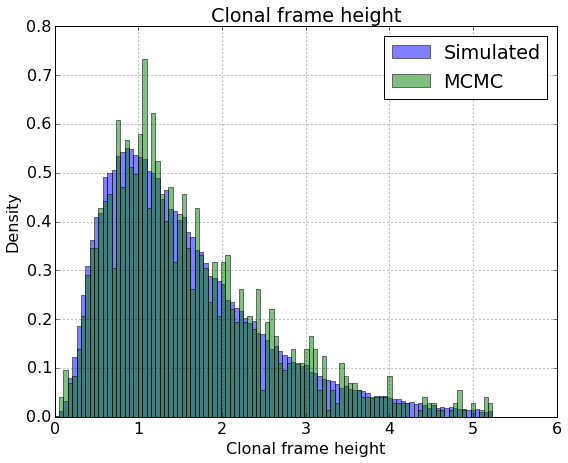

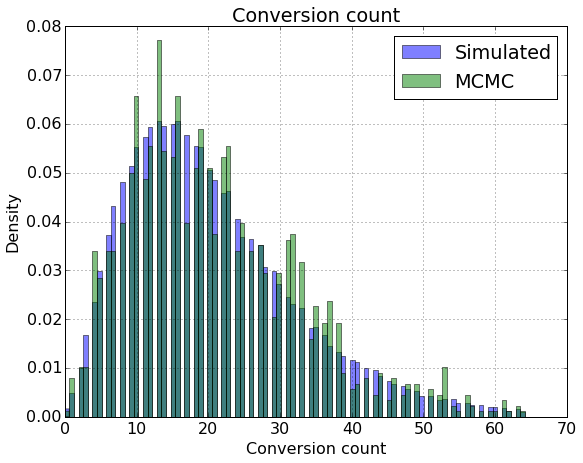

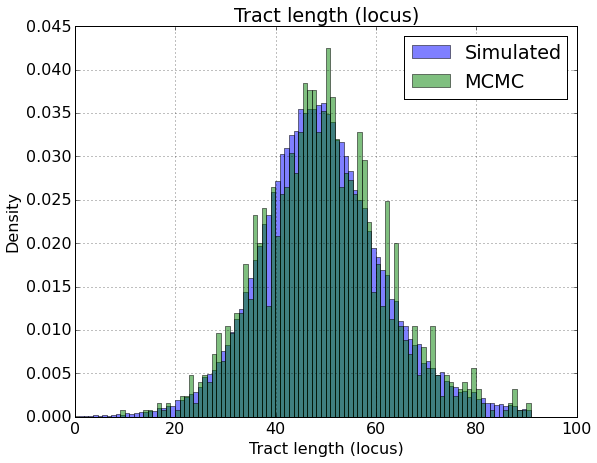

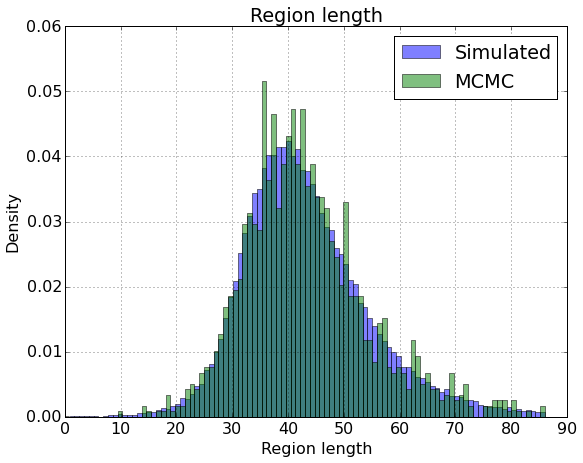

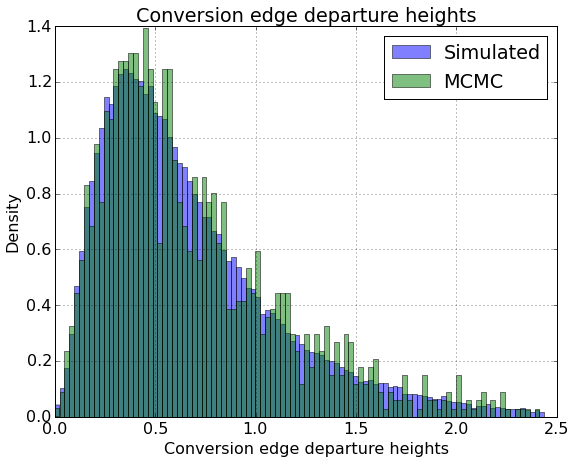

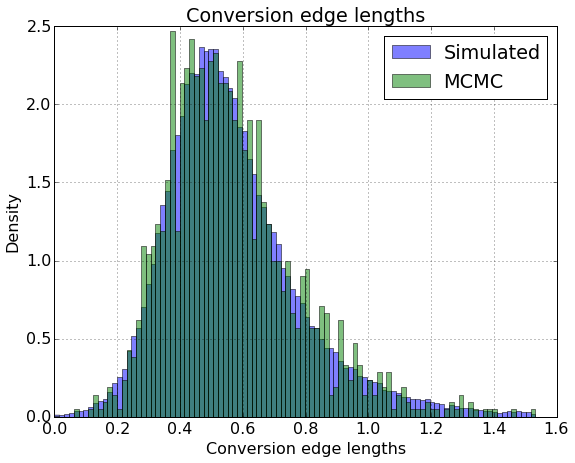

In [35]:
dfs = read_table('ACGsimulations/simulateACGs5taxon.stats')
df = removeBurnin(read_table('CFOperatorTests/CFWilsonBaldingTest5taxon.stats'))
drawAllComparisonPlots(df, dfs)

## CF Conversion Swap operator

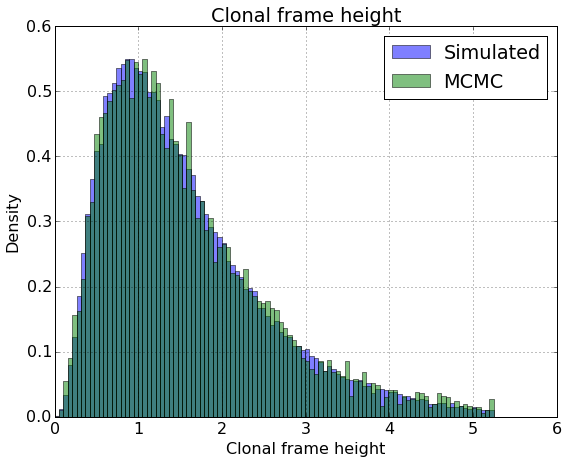

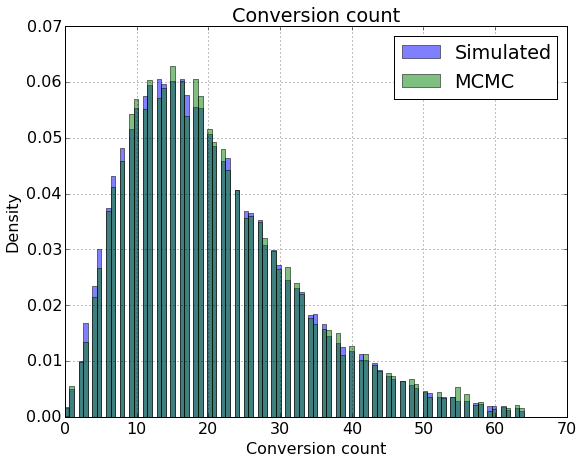

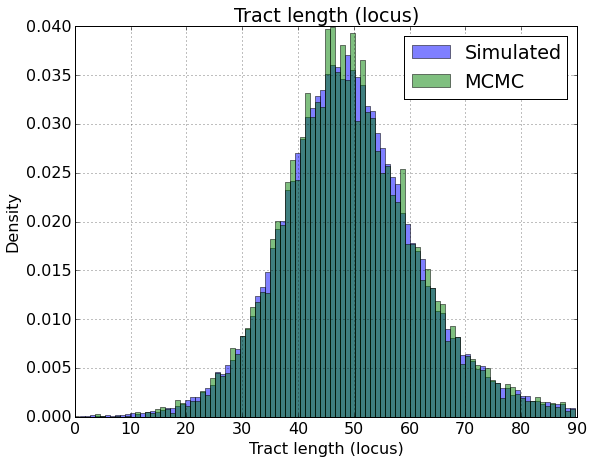

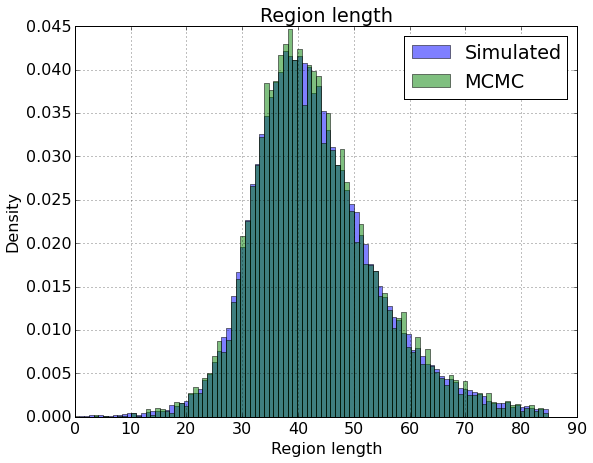

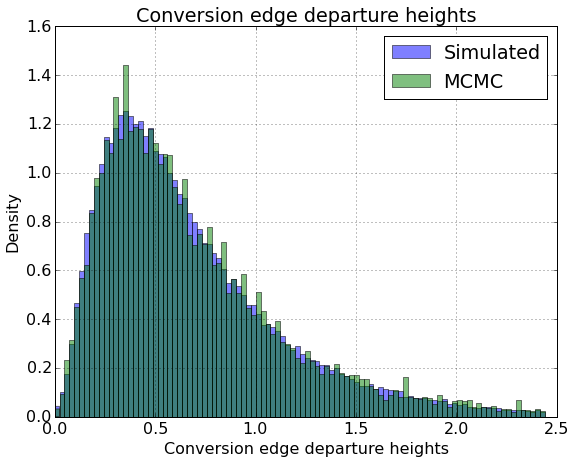

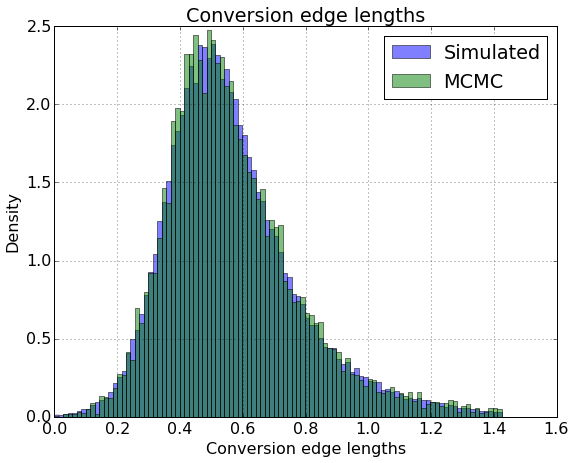

In [2]:
dfs = read_table('ACGsimulations/simulateACGs5taxon.stats')
df = removeBurnin(read_table('CFOperatorTests/CFConversionSwapTest5taxon.stats'))
drawAllComparisonPlots(df, dfs)

## CF Subtree Slide operator

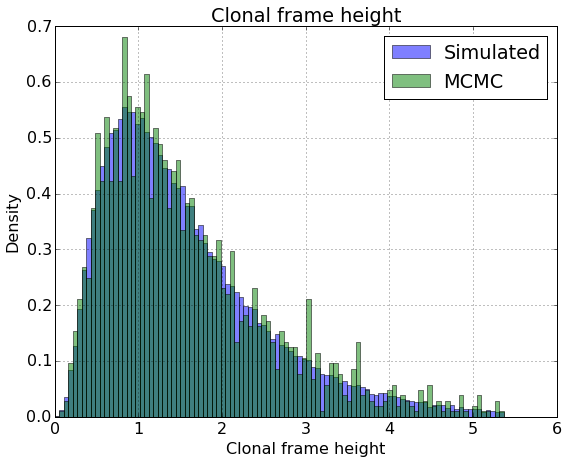

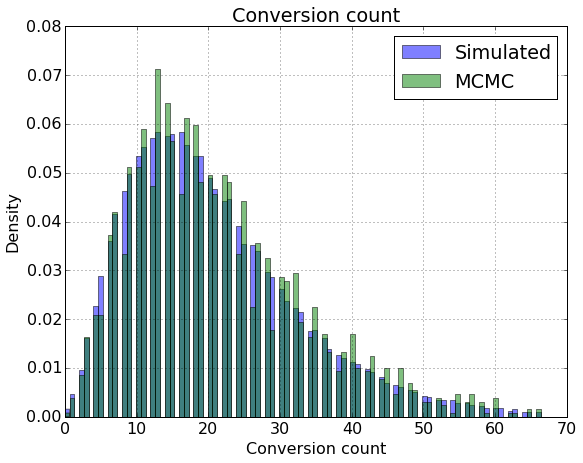

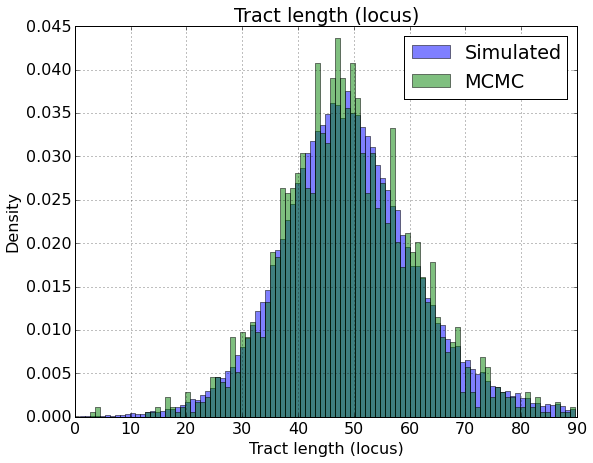

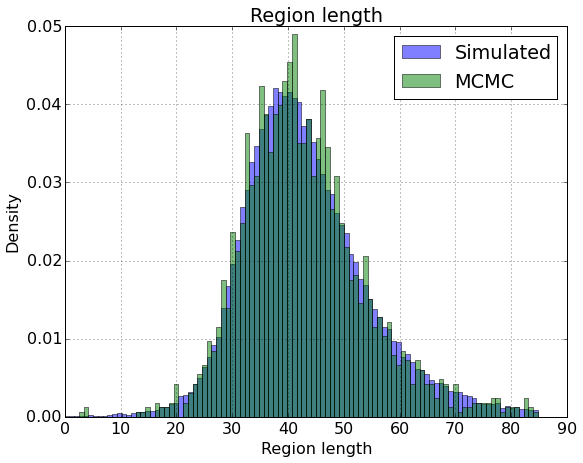

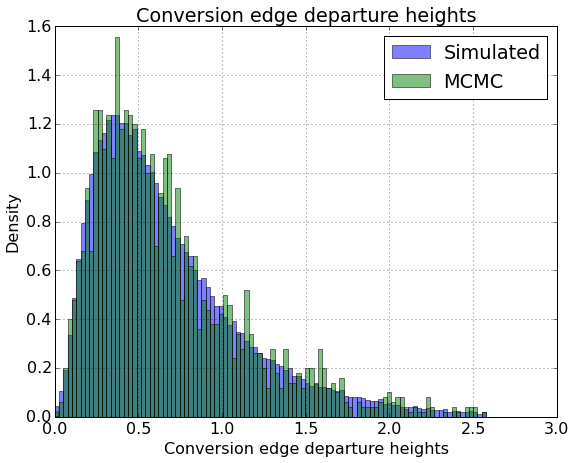

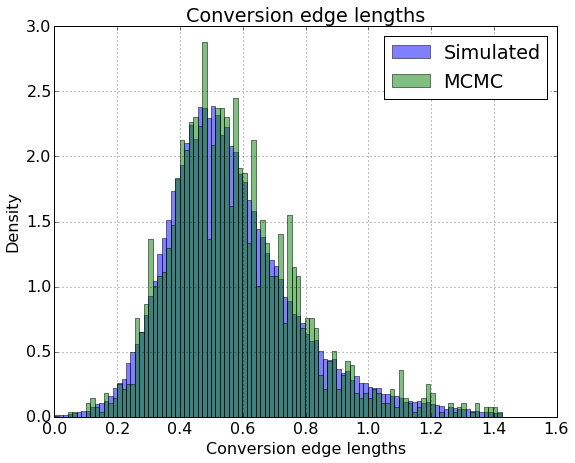

In [37]:
dfs = read_table('ACGsimulations/simulateACGs5taxon.stats')
df = removeBurnin(read_table('CFOperatorTests/CFSubtreeSlideTest5taxon.stats'))
drawAllComparisonPlots(df, dfs)

## CF Subtree Exchange operator

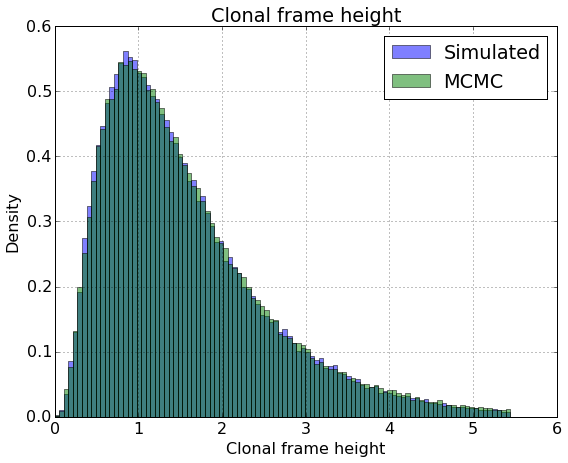

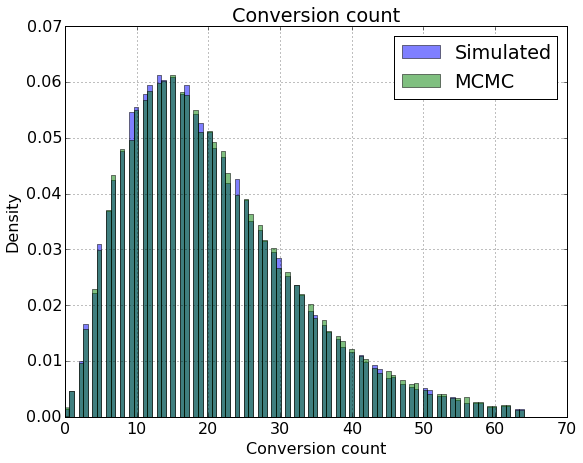

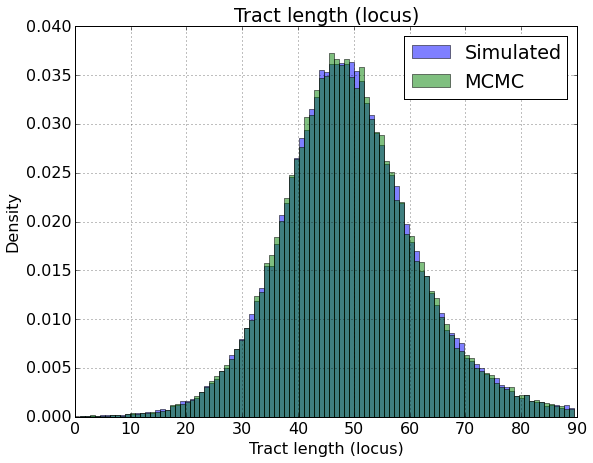

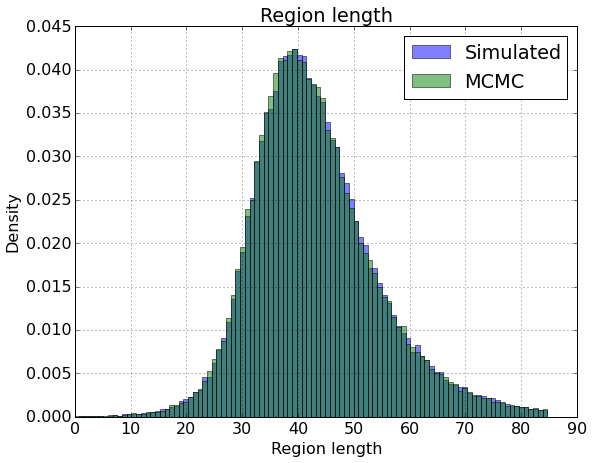

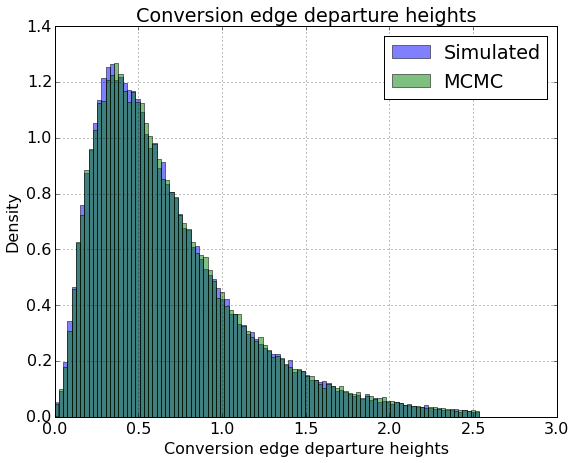

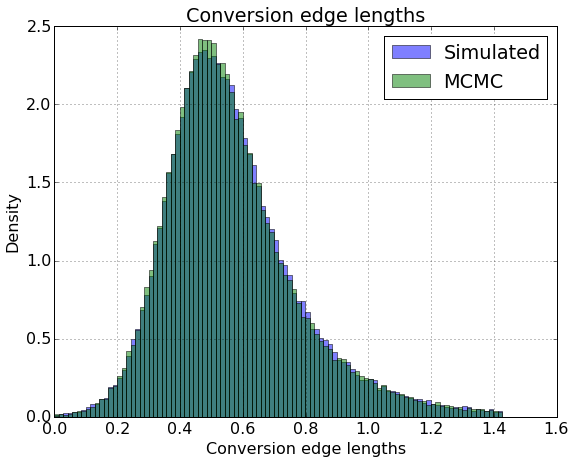

In [50]:
dfs = read_table('ACGsimulations/simulateACGs5taxon.stats')
df = removeBurnin(read_table('CFOperatorTests/CFSubtreeExchangeTest5taxon.stats'))
drawAllComparisonPlots(df, dfs)

# Serially sampled (All operators)

The following series of plots demonstrate that the sampler draws from the correct distribution when the leaf times of the ARGs are heterochronous.

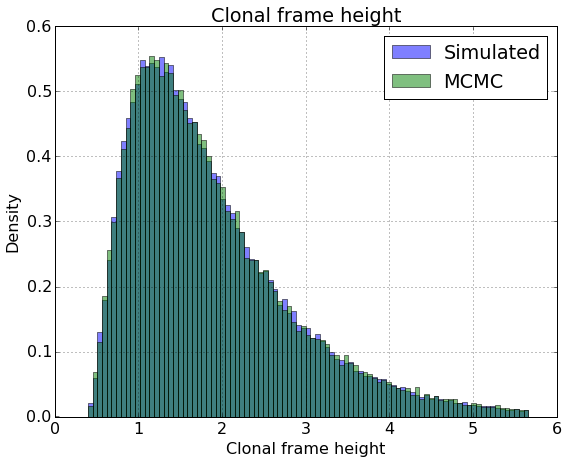

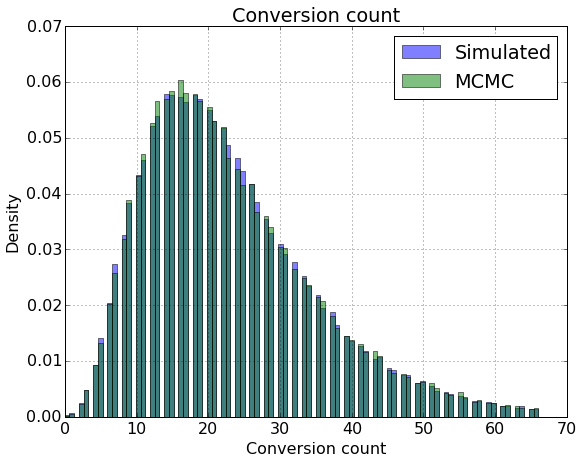

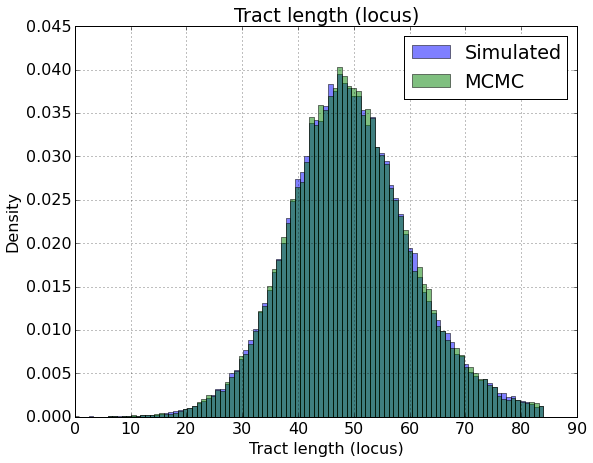

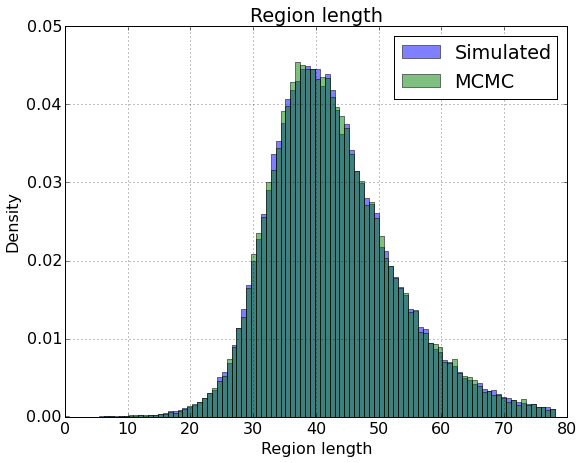

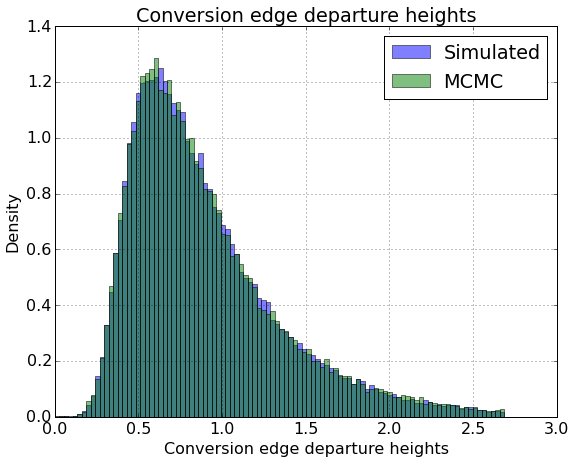

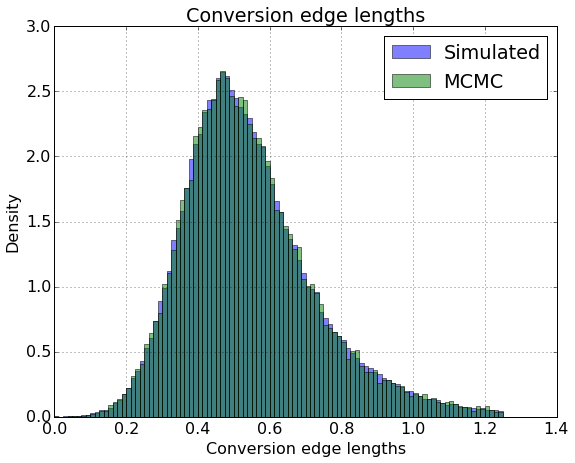

In [65]:
dfs = read_table('ACGsimulations/simulateACGs5taxonSerialSampling.stats')
df = removeBurnin(read_table('allOperatorTests/allOperatorTestSeriallySampled.stats'))
drawAllComparisonPlots(df, dfs)

# Serially sampled, multiple loci (All operators)

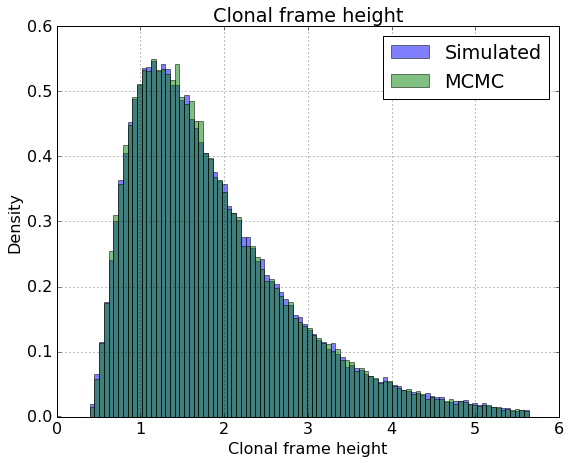

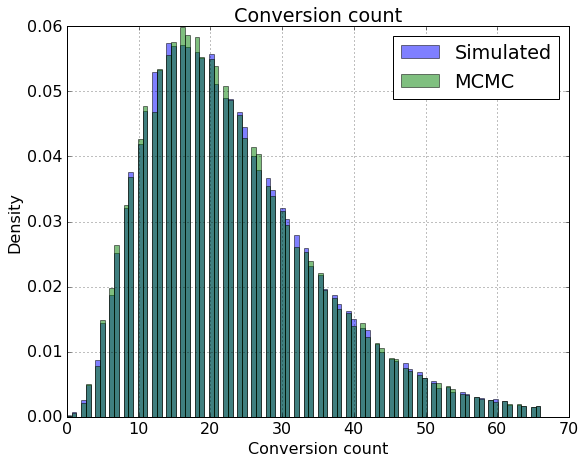

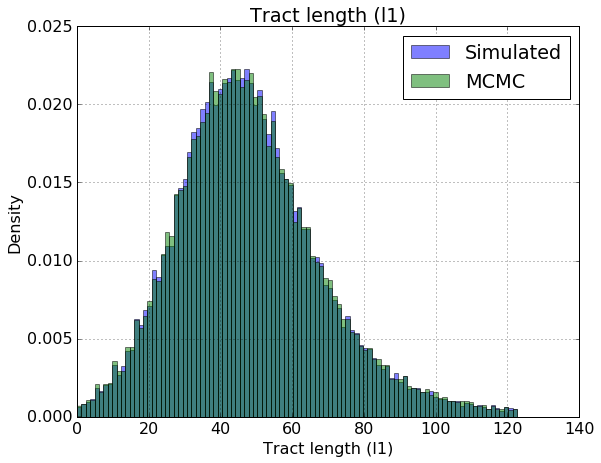

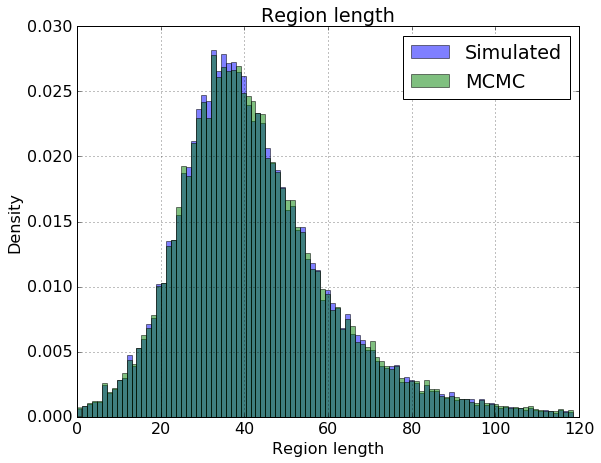

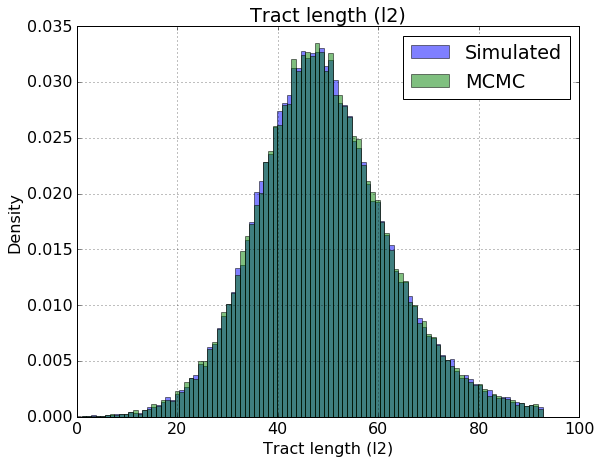

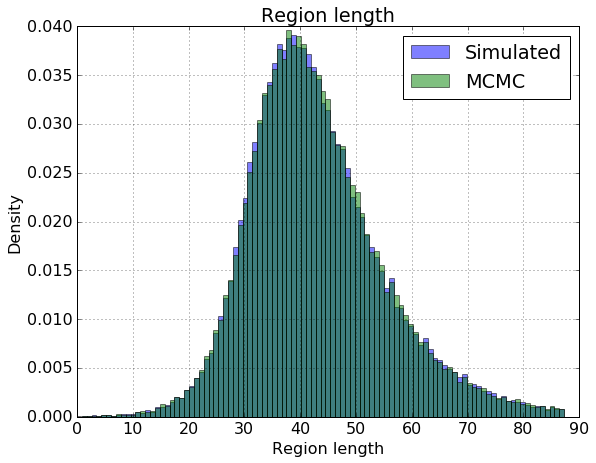

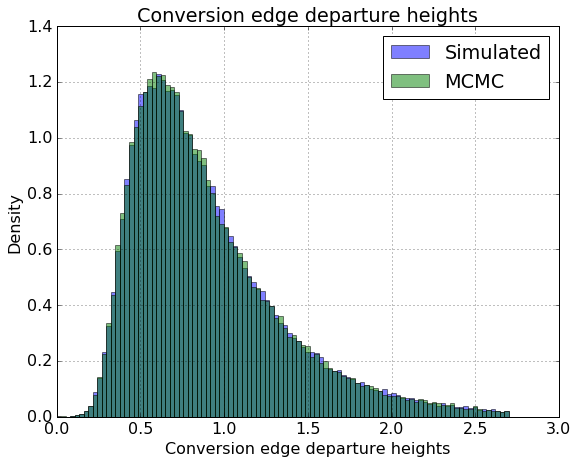

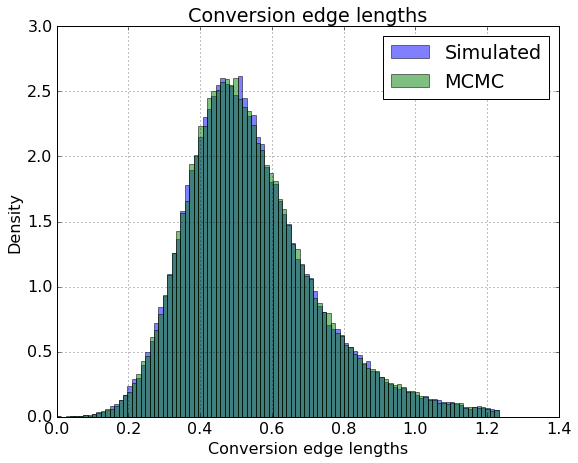

In [6]:
dfs = read_table('ACGsimulations/simulateACGs5taxonMultiLocus.stats')
df = removeBurnin(read_table('allOperatorTests/allOperatorTestSSMultiLocus.stats'))
drawAllComparisonPlots(df, dfs, ['l1', 'l2'])

# Tract site distributions

There are subtleties in getting the distribution of starting and ending sites to agree precisely with the model.  Here we look at these distributions for a 5 taxon example with very short sequence lengths that will magnify any problems.

In [4]:
dfs = read_table('ACGsimulations/simulateACGs5taxonShortSSML.stats')
df = removeBurnin(read_table('allOperatorTests/allOperatorTestShortSSML.stats'))

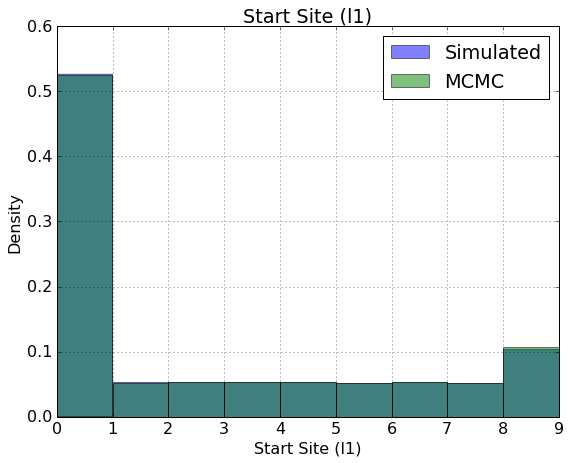

In [12]:
drawComparisonPlot(df, dfs, 'acg.l1.randomStartSite','Start Site (l1)', bins=range(10))

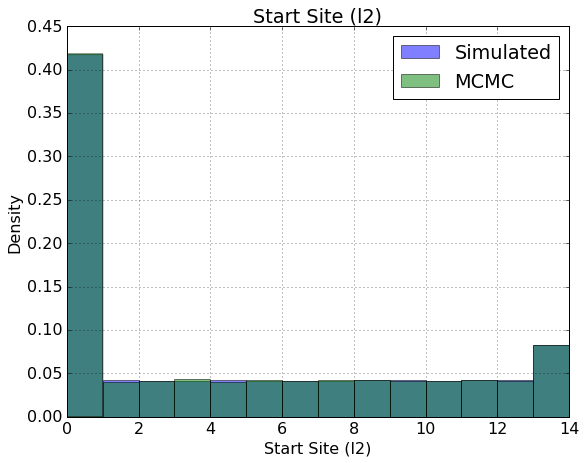

In [11]:
drawComparisonPlot(df, dfs, 'acg.l2.randomStartSite','Start Site (l2)', bins=range(15))

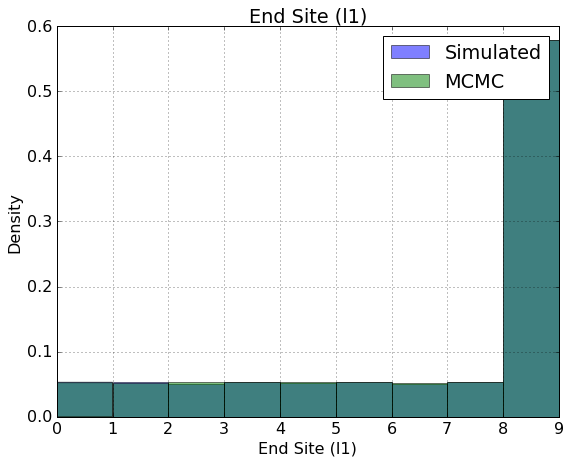

In [10]:
drawComparisonPlot(df, dfs, 'acg.l1.randomEndSite','End Site (l1)', bins=range(10))

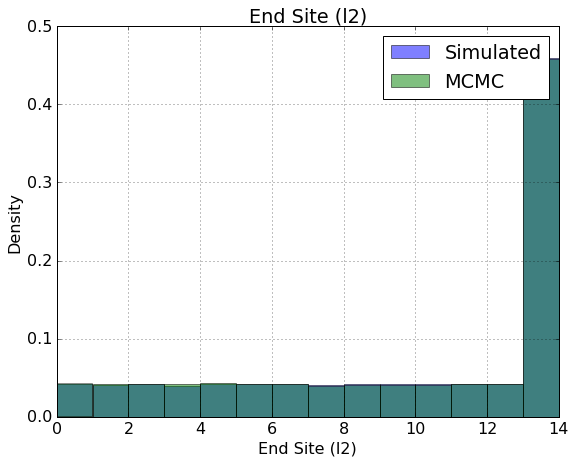

In [9]:
drawComparisonPlot(df, dfs, 'acg.l2.randomEndSite','End Site (l2)', bins=range(15))

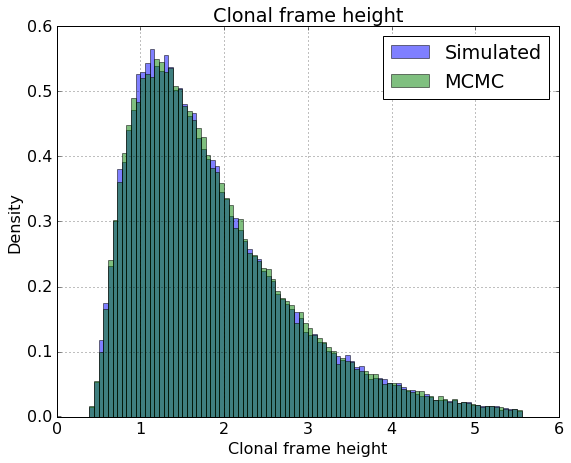

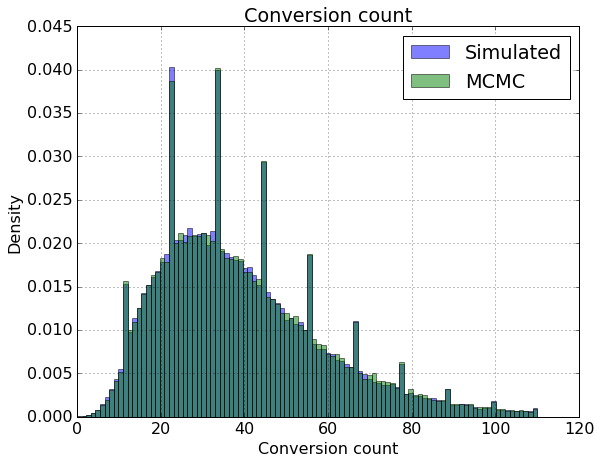

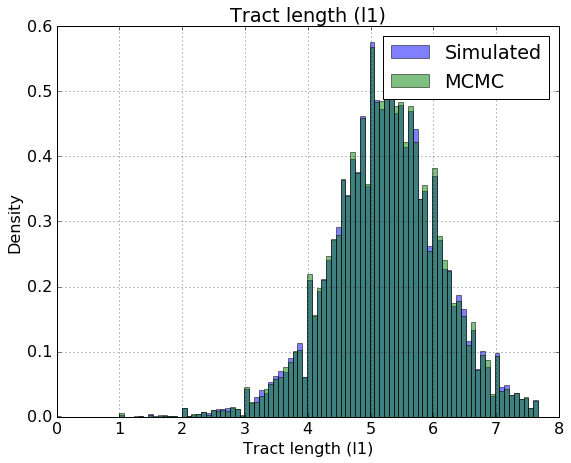

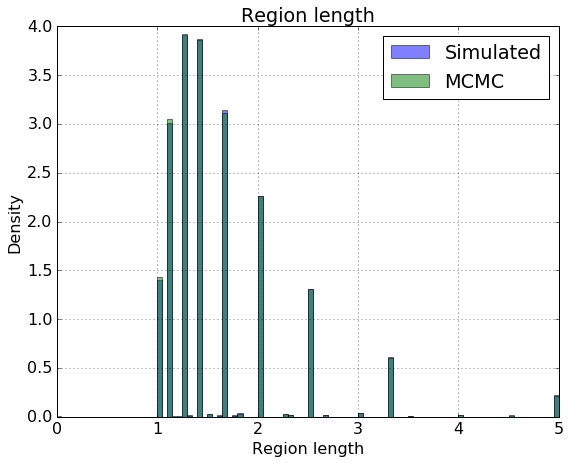

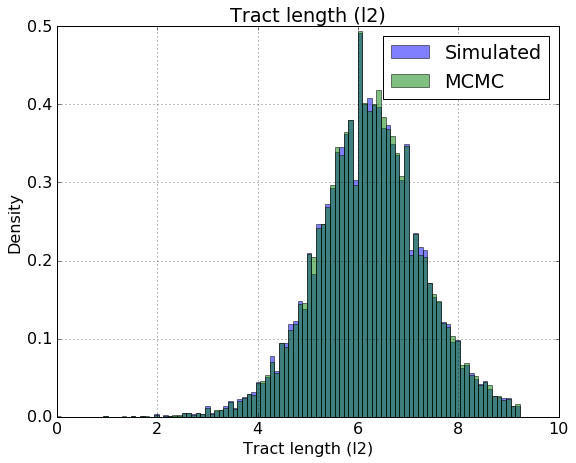

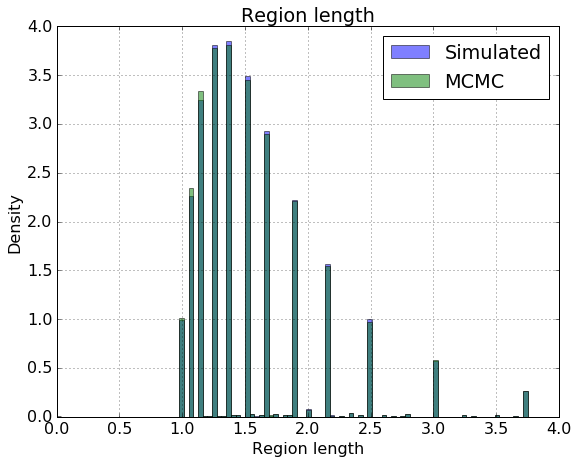

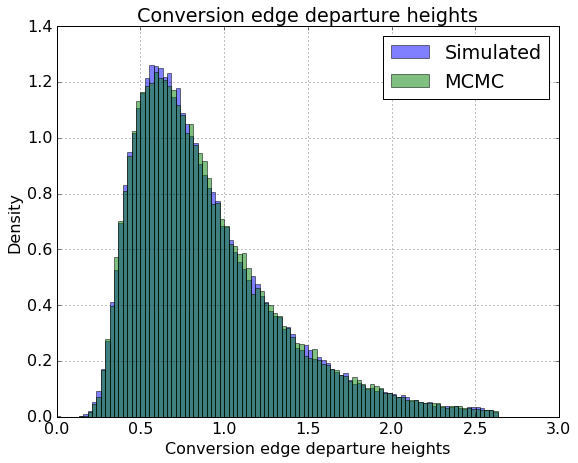

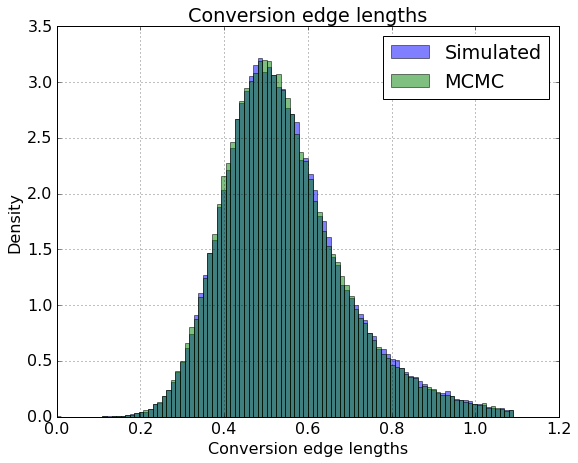

In [13]:
drawAllComparisonPlots(df, dfs, ['l1', 'l2'])